In [1]:
import csv
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input, Concatenate, Dot, Lambda

In [3]:
# Read data from text
with open('train_snli.txt') as file:
    data = file.readlines()



with open('data.csv', 'w', newline= '') as csvfile:
    filenames = ['source_txt', 'plagiarism_txt', 'label']
    writer = csv.DictWriter(csvfile, fieldnames=filenames)
    
    writer.writeheader()
    for line in tqdm(data):
        parts = line.strip().split('\t')
        source_txt = parts[0]
        plagiarishm_txt = parts[1]
        label = int(parts[2])
        
        writer.writerow({
            'source_txt' : source_txt,
            'plagiarism_txt' : plagiarishm_txt,
            'label' : label
        })
print('CSV file created successfully...')


  0%|          | 0/367373 [00:00<?, ?it/s]

CSV file created successfully...


In [4]:
df = pd.read_csv('data.csv')

In [5]:
df.head()

,source_txt,plagiarism_txt,label
0,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",0
1,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",1
2,Children smiling and waving at camera,There are children present,1
3,Children smiling and waving at camera,The kids are frowning,0
4,A boy is jumping on skateboard in the middle o...,The boy skates down the sidewalk.,0


In [7]:
df.describe()

,label
count,367373.000000
mean,0.499239
std,0.500000
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [8]:
df.shape

(367373, 3)

In [9]:
df.isnull().sum()

source_txt        0
plagiarism_txt    4
label             0
dtype: int64

In [10]:
df.duplicated().sum()

454

In [11]:
df.dropna(inplace=True)

In [13]:
df.drop_duplicates(inplace=True)

In [14]:
print(df.isnull().sum())
print(df.duplicated().sum())
print(df.shape)

source_txt        0
plagiarism_txt    0
label             0
dtype: int64
0
(366915, 3)


<Axes: xlabel='label'>

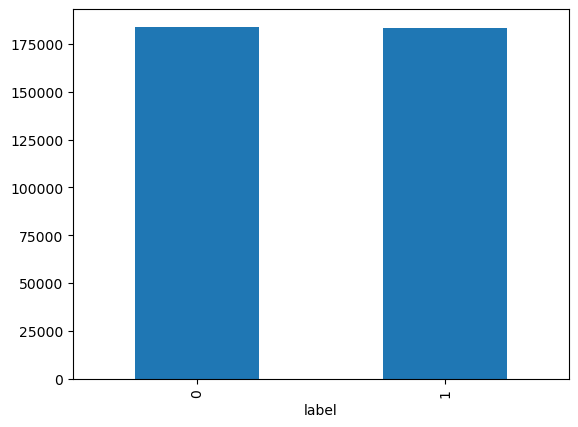

In [15]:
df['label'].value_counts().plot(kind='bar')

In [16]:
print(df['source_txt'][1])
print(df['plagiarism_txt'][1])

A person on a horse jumps over a broken down airplane.
A person is outdoors, on a horse.


In [17]:
import string

def preprocess_text(text):
    if isinstance(text, str):
        # Remove punctuation
        text = text.translate(str.maketrans("", "", string.punctuation))
        # Convert to lowercase
        text = text.lower()
    return text

In [18]:
df['source_txt'] = df['source_txt'].apply(preprocess_text)
df['plagiarism_txt'] = df['plagiarism_txt'].apply(preprocess_text)

In [19]:
df['source_txt'][1]

'a person on a horse jumps over a broken down airplane'

In [20]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['source_txt'] + '' + df['plagiarism_txt'])
X = tokenizer.texts_to_sequences(df['source_txt'] + '' + df['plagiarism_txt'])
X = pad_sequences(X)

In [21]:
y = df['label']

In [22]:
xtrain,xtest,ytrain,ytest = train_test_split(X,y,test_size=0.2)

In [23]:
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
model = Sequential([
    Embedding(input_dim = vocab_size, output_dim = embedding_dim, input_length = X.shape[1]),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])
model.summary()

C:\Users\Ashutosh\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [24]:
from keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [25]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Step 6: Train the model
model.fit(xtrain, ytrain, batch_size=64, epochs=1, validation_data=[xtest, ytest], callbacks=callback)

4587/4587 ━━━━━━━━━━━━━━━━━━━━ 1635s 352ms/step - accuracy: 0.7124 - loss: 0.5352 - val_accuracy: 0.7853 - val_loss: 0.4404


In [26]:
import pickle
model.save('model.h5')
with open('tokenizer.pkl','wb') as file:
    pickle.dump(tokenizer, file)

In [27]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load your model
model = load_model('model.h5')

# Quantize the model
quantized_model = tf.keras.models.clone_model(model)
quantized_model.set_weights(model.get_weights())
quantized_model.compile(optimizer=model.optimizer, loss=model.loss)

# Save the quantized model
quantized_model.save('quantized_model.h5')

In [28]:
def pre_text(text):
    sequences = tokenizer.texts_to_sequences([text])
    padded_sequences = pad_sequences(sequences, maxlen = 111)
    return padded_sequences
def prdict_plagiarism(text):
    process_text = pre_text(text)
    predictions = model.predict(process_text)
    return predictions[0][0]

new_text = "a few people in a restaurant setting one of them is drinking orange juice"
predictions = prdict_plagiarism(new_text)
if predictions >  .5 :
    
    print('This Text Has Plagiarism With Similarity Score IS:  ', predictions)
else:
    print("This Text Has No Plagiarism")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
This Text Has No Plagiarism


In [29]:
df['plagiarism_txt'][50]

'two adults walk across a street'

In [30]:
print(df['source_txt'][10])
print(df['plagiarism_txt'][10])

a few people in a restaurant setting one of them is drinking orange juice
the diners are at a restaurant
